In [1]:
from abflow.structure import write_to_pdb
from train import setup_model
from utils.load_data import Loader
from utils.utils import load_config

model_name = "predict_backbone_HCDR3_200e"
seed = 42
num_structures = 1

device = "cuda: 0"
checkpoint_path = f"/home/jovyan/flow-matching-datavol/model/{model_name}/epoch=199.ckpt"
load_optimizer = False
config_path = f"/home/jovyan/flow-matching-datavol/model/{model_name}/config.yaml"

# load model
config = load_config(config_path)
config["num_workers"] = 1
config["batch_size"] = 1
config["devices"] = 1
model = setup_model(config, checkpoint_path=checkpoint_path, load_optimizer=load_optimizer)

# redesign complex
ds_loader = Loader(config, dataset_name=config["dataset"])

/home/jovyan/.conda/envs/abflow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of clusters found: 3145
Number of PDB IDs: 10933
Number of RAbD id: 60
Number of test id (by searching entries of RAbD is): 84
Number of test id (by removing repeats, final): 58
Number of SAbDab IDs (does not need to be unique): 16269
Final number of total SAbDab IDs (different entry id can be associated with same pdb of different chains): 10988
Total number of clusters in training: 3073
Total number of clusters in validation: 10
Total number of clusters in test: 56
Number of structuress in the train split: 10564
Number of structures after final filtering: 6314
Number of clusters found: 3145
Number of PDB IDs: 10933
Number of RAbD id: 60
Number of test id (by searching entries of RAbD is): 84
Number of test id (by removing repeats, final): 58
Number of SAbDab IDs (does not need to be unique): 16269
Final number of total SAbDab IDs (different entry id can be associated with same pdb of different chains): 10988
Total number of clusters in training: 3073
Total number of clusters in

# debug

In [3]:
from abflow.structure import write_to_pdb
import os
import numpy as np
import torch

from abflow.data_utils import mask_data

data_iter = iter(ds_loader.test_loader)
template_complex = next(data_iter)

res_type = template_complex['res_type']
CA_coords = template_complex['CA_coords']
redesign_mask = template_complex['redesign_mask']
res_type_masked = mask_data(res_type, 0.0, redesign_mask)
CA_coords_masked = mask_data(CA_coords, 0.0, redesign_mask)

print("------- redesigned sequence and structure without pre mask -------")
print("Unmasked redesign sequence in input dict to the model")
print(template_complex['res_type'][redesign_mask.bool()])
print(template_complex['CA_coords'][redesign_mask.bool()])

# redesign
redesign_complexes, redesign_trajs = model._generate_complexes(template_complex, seed)

print(redesign_complexes['res_type'][redesign_mask.bool()])
print(redesign_complexes['CA_coords'][redesign_mask.bool()])

print("------- redesigned sequence and structure with pre mask -------")
template_complex['res_type'] = res_type_masked
template_complex['CA_coords'] = CA_coords_masked
print("Masked redesign sequence in input dict to the model")
print(template_complex['res_type'][redesign_mask.bool()])
print(template_complex['CA_coords'][redesign_mask.bool()])

# redesign
redesign_complexes, redesign_trajs = model._generate_complexes(template_complex, seed)

print(redesign_complexes['res_type'][redesign_mask.bool()])
print(redesign_complexes['CA_coords'][redesign_mask.bool()])

------- redesigned sequence and structure without pre mask -------
Unmasked redesign sequence in input dict to the model
tensor([ 4, 14,  2, 17,  4,  4,  2, 17, 14,  0, 15, 15, 15, 17, 11, 11, 10,  6])
tensor([[ -8.0120,  -4.6382,   6.1858],
        [ -6.4210,  -3.6082,   9.5158],
        [ -6.5550,   0.1588,   8.8288],
        [ -3.2670,  -0.2812,   6.8598],
        [ -3.2090,  -3.3832,   4.6068],
        [ -4.6370,  -6.8812,   3.9398],
        [ -3.5520,  -8.6782,   7.1348],
        [ -5.7460, -11.8252,   6.8278],
        [  8.0830,   0.3978,  -9.8062],
        [  5.0790,   2.7088, -10.3892],
        [  3.8680,   4.9548, -13.2232],
        [  3.1160,   7.6758, -10.6402],
        [  4.1690,   8.5008,  -7.0632],
        [  3.1150,   6.4468,  -4.0192],
        [  3.3410,   7.3398,  -0.2972],
        [  3.5140,   3.8028,   1.1588],
        [  4.1590,   0.3698,  -0.3922],
        [  2.9550,  -3.0602,   0.7728]])
tensor([15, 19, 15,  5,  2, 15, 19, 15, 15, 15, 16,  9,  3, 15, 10, 15,  0, 1

In [6]:
from abflow.structure import write_to_pdb
import os
import numpy as np
import torch

model.eval()
device = torch.device("cuda:0")
model.to(device)
design_mode = ["backbone"]

data_iter = iter(ds_loader.test_loader)
template_complex = next(data_iter)
redesign_complexes, redesign_trajs = model.generate(template_complex, design_mode=design_mode, seed=seed)

des_dir = f"/home/jovyan/flow-matching-datavol/model/{model_name}/desabs"
if not os.path.exists(des_dir):
    os.makedirs(des_dir)
write_to_pdb(data=template_complex["full_complex"], filepath=f"{des_dir}/full_complex.pdb")
print("true id is", template_complex["full_complex"]["id"])
write_to_pdb(data=template_complex, filepath=f"{des_dir}/WT.pdb")
write_to_pdb(data=redesign_complexes, filepath=f"{des_dir}/DesAb.pdb")
# write traj to pdb - remember plddt per residue is also in redesign_complexes. 
for t, des_t in enumerate(redesign_trajs):
    write_to_pdb(data=des_t, filepath=f"{des_dir}/DesAb_{t}.pdb")

true id is ['4ffv_H_L_A']


# Benchmark

## AbFlow

In [8]:
# get pdb id
test_dataset = ds_loader.test_dataset
test_ids = test_dataset.split_ids

# get the raw data
for test_id in test_ids:
    test_data = test_dataset._get_structure(test_id)
    print(test_data.keys())
    break
# preprocess data as inputs

# for each test complex, generate 100 designs

# get coords, seq, redesign mask

dict_keys(['id', 'heavy', 'heavy_seqmap', 'light', 'light_seqmap', 'antigen', 'antigen_seqmap', 'structure_type', 'light_ctype', 'quality', 'resolution'])


# DiffAb

In [27]:
from abflow.structure import extract_pdb_structure
from abflow.model.metrics import get_rmsd, get_aar, get_bb_clash_violation, get_bb_bond_angle_violation, get_bb_bond_length_violation
from abflow.data_utils import inv_mask

true_pdb_path = "./benchmarks/diffab/results/codesign_single/7DK2_AB_C.pdb_2024_07_27__13_15_38/reference.pdb"
pred_pdb_path = "./benchmarks/diffab/results/codesign_single/7DK2_AB_C.pdb_2024_07_27__13_15_38/H_CDR3/0030.pdb"
CDR_redesign = "HCDR3"

true_N_coords, true_CA_coords, true_C_coords, true_CB_coords, true_res_type, true_cdr_masks = extract_pdb_structure(true_pdb_path, scheme="chothia")
pred_N_coords, pred_CA_coords, pred_C_coords, pred_CB_coords, pred_res_type, pred_cdr_masks = extract_pdb_structure(pred_pdb_path, scheme="chothia")
redesign_mask = true_cdr_masks[CDR_redesign]

true_N_coords = true_N_coords.unsqueeze(0)
true_CA_coords = true_CA_coords.unsqueeze(0)
true_C_coords = true_C_coords.unsqueeze(0)
true_CB_coords = true_CB_coords.unsqueeze(0)
true_res_type = true_res_type.unsqueeze(0)
redesign_mask = redesign_mask.unsqueeze(0)

pred_N_coords = pred_N_coords.unsqueeze(0)
pred_CA_coords = pred_CA_coords.unsqueeze(0)
pred_C_coords = pred_C_coords.unsqueeze(0)
pred_CB_coords = pred_CB_coords.unsqueeze(0)
pred_res_type = pred_res_type.unsqueeze(0)

true_bb_coords = [true_N_coords, true_CA_coords, true_C_coords]
pred_bb_coords = [pred_N_coords, pred_CA_coords, pred_C_coords]


print("Expect perfection")
print("DiffAb aar: ", get_aar(pred_res_type, true_res_type, masks=[inv_mask(redesign_mask)]))
print("DiffAb backbone clash: ", get_bb_clash_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks_dim_1=[inv_mask(redesign_mask)]))
print("DiffAb backbone bond angle violation: ", get_bb_bond_angle_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks=[inv_mask(redesign_mask)]))
print("DiffAb backbone bond length violation: ", get_bb_bond_length_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks=[inv_mask(redesign_mask)]))

print("DiffAb aar: ", get_aar(pred_res_type, true_res_type, masks=[redesign_mask]))
print("DiffAb rmsd: ", get_rmsd(pred_bb_coords, true_bb_coords, masks=[redesign_mask]))
print("DiffAb backbone clash: ", get_bb_clash_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks_dim_1=[redesign_mask]))
print("DiffAb backbone bond angle violation: ", get_bb_bond_angle_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks=[redesign_mask]))
print("DiffAb backbone bond length violation: ", get_bb_bond_length_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks=[redesign_mask]))

[INFO] Chain C does not contain valid Fv region for scheme chothia.
[INFO] Chain C does not contain valid Fv region for scheme chothia.
Expect perfection
DiffAb aar:  tensor([0.9829])
DiffAb backbone clash:  (tensor([0.]), tensor([0.]))
DiffAb backbone bond angle violation:  (tensor([0.0060]), tensor([0.0073]))
DiffAb backbone bond length violation:  (tensor([0.1808]), tensor([0.0122]))
DiffAb aar:  tensor([0.5000])
DiffAb rmsd:  tensor([2.7230])
DiffAb backbone clash:  (tensor([0.0002]), tensor([0.2500]))
DiffAb backbone bond angle violation:  (tensor([0.0185]), tensor([0.2500]))
DiffAb backbone bond length violation:  (tensor([0.0904]), tensor([0.3750]))


In [26]:
redesign_mask

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0

# MEAN

# Benchmark Evaluation

# Plots

In [11]:
import torch
from abflow.visualization import plot_plddt, plot_aa_distribution
from abflow.model.metrics import get_batch_lddt

model.eval()
device = torch.device("cuda:0")
model.to(device)
design_mode = ["sequence"]
test_dataloader = ds_loader.test_loader

with torch.no_grad():
    res_lddt_list = []
    res_plddt_list = []
    batch_lddt_list = []
    batch_plddt_list = []
    true_seq_list = []
    pred_seq_list = []
    for test_complex in test_dataloader:
        redesign_complex, _ = model.generate(test_complex, design_mode=design_mode, seed=seed)
        res_lddt = redesign_complex['lddt'][redesign_complex['redesign_mask'].bool()]
        res_plddt = redesign_complex['plddt'][redesign_complex['redesign_mask'].bool()]
        batch_lddt = get_batch_lddt(redesign_complex['lddt'], [redesign_complex['redesign_mask']])
        batch_plddt = get_batch_lddt(redesign_complex['plddt'], [redesign_complex['redesign_mask']])
        true_seq = test_complex['res_type'][test_complex['redesign_mask'].bool()]
        pred_seq = redesign_complex['res_type'][redesign_complex['redesign_mask'].bool()]

        res_lddt_list.append(res_lddt)
        res_plddt_list.append(res_plddt)
        batch_lddt_list.append(batch_lddt)
        batch_plddt_list.append(batch_plddt)
        true_seq_list.append(true_seq)
        pred_seq_list.append(pred_seq)
    res_lddt = torch.cat(res_lddt_list, dim=0).cpu()
    res_plddt = torch.cat(res_plddt_list, dim=0).cpu()
    batch_lddt = torch.cat(batch_lddt_list, dim=0).cpu()
    batch_plddt = torch.cat(batch_plddt_list, dim=0).cpu()
    true_seq = torch.cat(true_seq_list, dim=0).cpu()
    pred_seq = torch.cat(pred_seq_list, dim=0).cpu()

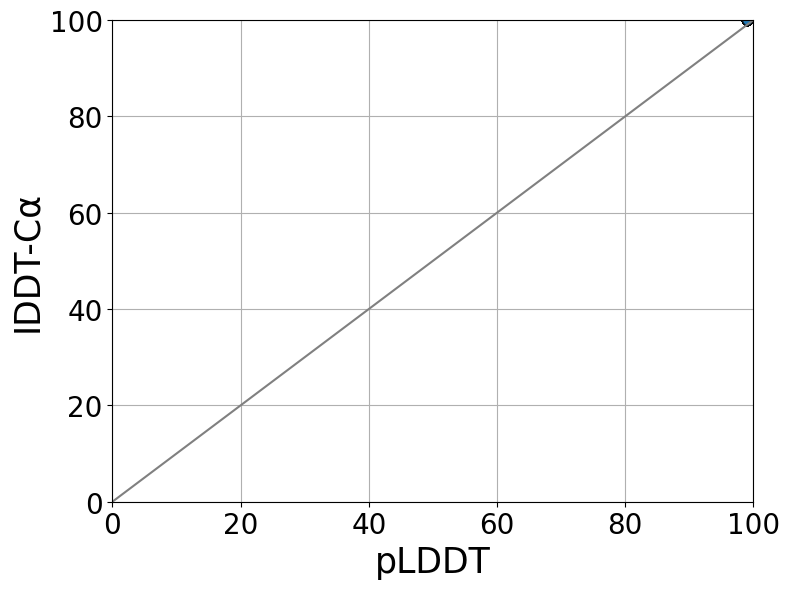

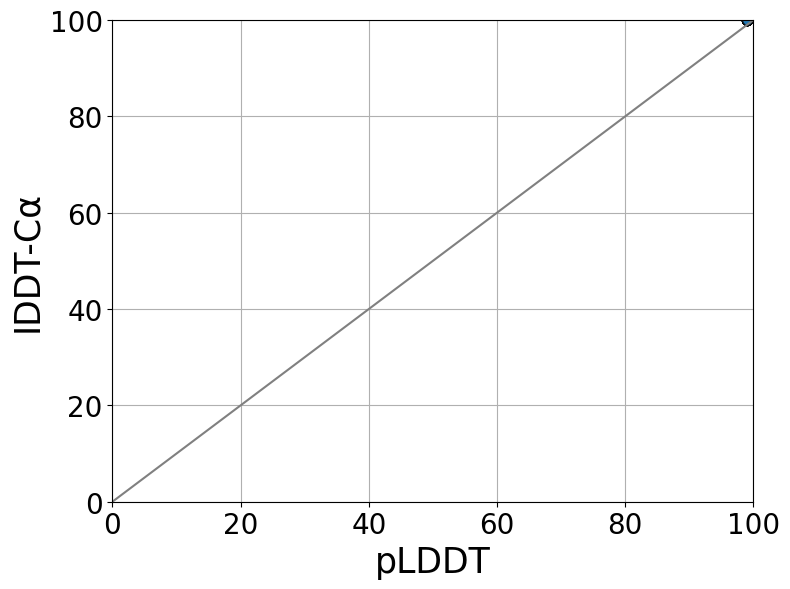

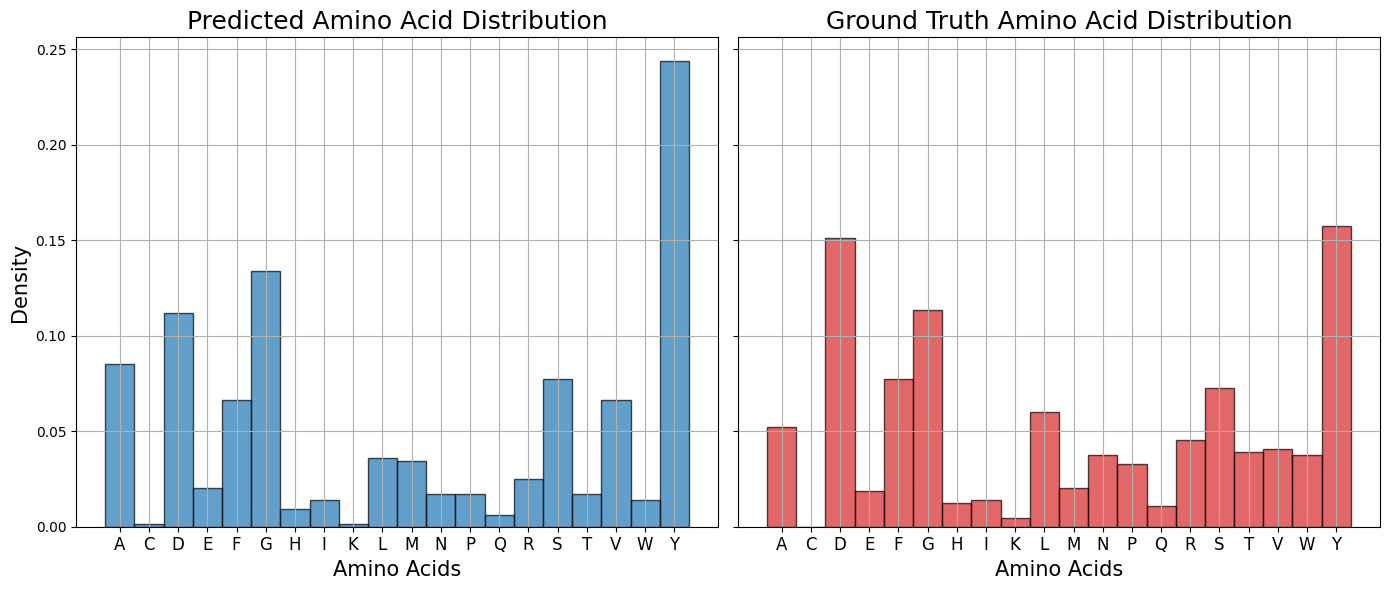

In [12]:
# plot_plddt(lddt, plddt, save_path='./figures/plddt_plot.pdf')
plot_plddt(res_lddt, res_plddt)
plot_plddt(batch_lddt, batch_plddt)
plot_aa_distribution(pred_seq, true_seq)